In [1]:
import numpy as np
import matplotlib.pyplot as plt
from converters import convert_from_file
from deskew import deskew
from sklearn import svm
from sklearn.model_selection import train_test_split
from time import perf_counter

In [2]:
# we need to scale the numbers down to reduce running time
x_train = convert_from_file('train-images.idx3-ubyte')/255.0
y_train = convert_from_file('train-labels.idx1-ubyte')
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)
x_train_deskew = []
x_val_deskew = []
print("Train set: %d cases." % (len(y_train)))
print("Validation set: %d cases." % len(y_val))
tic = perf_counter()
for img in x_train:
    x_train_deskew.append(deskew(img))
for img in x_val:
    x_val_deskew.append(deskew(img))
toc = perf_counter()
print("Time spent deskewing: %.4f seconds." % (toc - tic))

Train set: 54000 cases.
Validation set: 6000 cases.
Time spent deskewing: 25.5662 seconds.


In [3]:
# basic linear model without deskewing for comparison
basic_model = svm.LinearSVC()
tic = perf_counter()
basic_model.fit(x_train.reshape(len(x_train), 784), y_train)
score = basic_model.score(x_val.reshape(len(x_val), 784), y_val)
toc = perf_counter()
print("Basic linear model achieved accuracy of %.2f%%, spent %.4f seconds." % (score * 100, (toc - tic)))

Basic linear model achieved accuracy of 91.82%, spent 88.1908 seconds.


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [4]:
# linear model with deskewing
linear_deskewed = svm.LinearSVC()
tic = perf_counter()
linear_deskewed.fit(np.array(x_train_deskew).reshape(len(x_train_deskew), 784), y_train)
score = linear_deskewed.score(np.array(x_val_deskew).reshape(len(x_val_deskew), 784), y_val)
toc = perf_counter()
print("Deskewed linear model achieved accuracy of %.2f%%, spent %.4f seconds." % (score * 100, (toc - tic)))

Deskewed linear model achieved accuracy of 95.20%, spent 143.6711 seconds.


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [5]:
# RBF kernel SVM
# recommended values are applied
kernel_svm = svm.SVC(gamma=0.05, C=5)
tic = perf_counter()
kernel_svm.fit(np.array(x_train_deskew).reshape(len(x_train_deskew), 784), y_train)
score = kernel_svm.score(np.array(x_val_deskew).reshape(len(x_val_deskew), 784), y_val)
toc = perf_counter()
print("Deskewed RBF kernel model achieved accuracy of %.2f%%, spent %.4f seconds." % (score * 100, (toc - tic)))

Deskewed RBF kernel model achieved accuracy of 98.97%, spent 710.2356 seconds.


In [6]:
# RBF kernel SVM is the best model found in our project, save this model to a file
import joblib
joblib.dump(kernel_svm, 'mnist_rbf_svm_model.pkl')

['mnist_rbf_svm_model.pkl']

In [7]:
# kernel approximation of RBF kernel SVM
from sklearn.kernel_approximation import (Nystroem, RBFSampler)
from sklearn import pipeline
feature_map_fourier = RBFSampler(gamma=.2, random_state=1)
feature_map_nystroem = Nystroem(gamma=.2, random_state=1)
fourier_approx_svm = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("svm", svm.LinearSVC())])

nystroem_approx_svm = pipeline.Pipeline([("feature_map", feature_map_nystroem),
                                        ("svm", svm.LinearSVC())])

sample_sizes = 350 * np.arange(2, 10)
fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []

for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    tic = perf_counter()
    nystroem_approx_svm.fit(np.array(x_train_deskew).reshape(len(x_train), 784), y_train)
    nystroem_times.append(perf_counter() - tic)

    tic = perf_counter()
    fourier_approx_svm.fit(np.array(x_train_deskew).reshape(len(x_train), 784), y_train)
    fourier_times.append(perf_counter() - tic)

    fourier_score = fourier_approx_svm.score(np.array(x_val_deskew).reshape(len(x_val), 784), y_val)
    nystroem_score = nystroem_approx_svm.score(np.array(x_val_deskew).reshape(len(x_val), 784), y_val)
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)

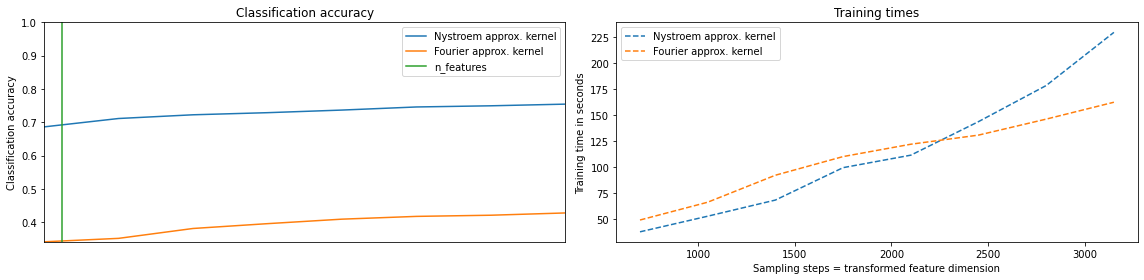

In [8]:
# plot the results:
plt.figure(figsize=(16, 4))
accuracy = plt.subplot(121)
# second y axis for timings
timescale = plt.subplot(122)

accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
timescale.plot(sample_sizes, nystroem_times, '--',
               label='Nystroem approx. kernel')

accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
timescale.plot(sample_sizes, fourier_times, '--',
               label='Fourier approx. kernel')

# vertical line for dataset dimensionality = 64
accuracy.plot([784, 784], [0, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc='best')
timescale.legend(loc='best')
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

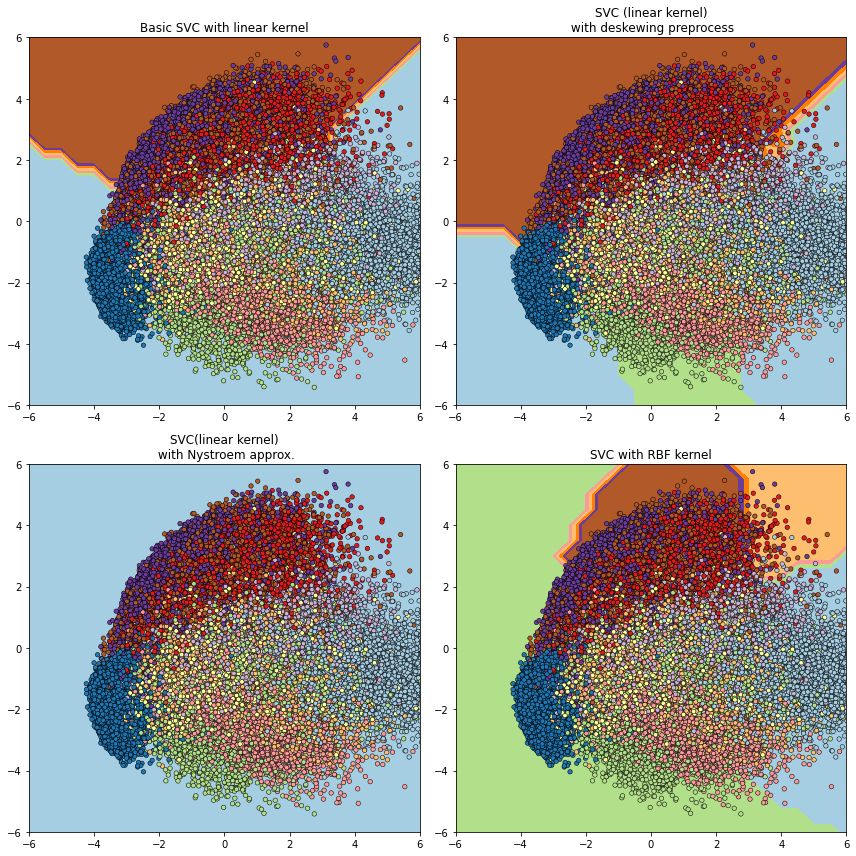

In [10]:
# print decision boundary
from sklearn.decomposition import PCA
# find principal components
data_points = x_train.reshape(len(x_train), 784)
pca = PCA(n_components=8).fit(data_points)
X = pca.transform(data_points)
multiples = np.arange(-6, 9, 0.5)
# steps along first component
first = multiples[:, np.newaxis] * pca.components_[0, :]
# steps along second component
second = multiples[:, np.newaxis] * pca.components_[1, :]
# combine
grid = first[np.newaxis, :, :] + second[:, np.newaxis, :]
flat_grid = grid.reshape(-1, data_points.shape[1])

# title for the plots
titles = ['Basic SVC with linear kernel',
          'SVC (linear kernel)\n with deskewing preprocess',
         'SVC(linear kernel)\n with Nystroem approx.',
         'SVC with RBF kernel']

plt.tight_layout()
plt.figure(figsize=(12, 12))

# predict and plot
for i, clf in enumerate((basic_model, linear_deskewed, nystroem_approx_svm, kernel_svm)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    Z = clf.predict(flat_grid)

    # Put the result into a color plot
    Z = Z.reshape(grid.shape[:-1])
    plt.contourf(multiples, multiples, Z, cmap=plt.cm.Paired)

    # Plot also the points
    plt.scatter(X[:, 0], X[:, 1], c=y_train, cmap=plt.cm.Paired, s=20, edgecolors=(0,0,0), linewidths=0.5)
    # adjust the axis so we can see the boundary
    plt.axis([-6, 6, -6, 6])
    plt.title(titles[i])
plt.tight_layout()
plt.show()